### **Amazon Example for Class**

![](https://images-eu.ssl-images-amazon.com/images/G/30/Consumables/Beauty/2023/header.png)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm
import cornac
from cornac.utils import cache
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.models import UserKNN, ItemKNN, SVD

**EDA**

In [3]:
amazon_ratings = pd.read_csv('ratings_Beauty.csv')
amazon_ratings.drop('Timestamp', axis=1, inplace=True)
amazon_ratings.head()

,UserId,ProductId,Rating
0,A39HTATAQ9V7YF,0205616461,5.0
1,A3JM6GV9MNOF9X,0558925278,3.0
2,A1Z513UWSAAO0F,0558925278,5.0
3,A1WMRR494NWEWV,0733001998,4.0
4,A3IAAVS479H7M7,0737104473,1.0


In [4]:
amazon_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023070 entries, 0 to 2023069
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   UserId     object 
 1   ProductId  object 
 2   Rating     float64
dtypes: float64(1), object(2)
memory usage: 46.3+ MB


In [5]:
amazon_ratings.isna().sum()

UserId       0
ProductId    0
Rating       0
dtype: int64

In [6]:
amazon_ratings.value_counts('Rating', normalize=True)

Rating
5.0    0.617241
4.0    0.152115
1.0    0.090844
3.0    0.083927
2.0    0.055873
Name: proportion, dtype: float64

In [7]:
# Unique Counts
df = amazon_ratings

unique_counts = df.nunique()
unique_values = [df[column].unique() for column in df.columns]
data_types = [str(amazon_ratings[column].dtype) for column in amazon_ratings.columns]
unique_counts_df = pd.DataFrame({'feature': amazon_ratings.columns, 'unique_count': unique_counts, 'unique_values': unique_values, 'data_type': data_types})
unique_counts_df

,feature,unique_count,unique_values,data_type
UserId,UserId,1210271,"[A39HTATAQ9V7YF, A3JM6GV9MNOF9X, A1Z513UWSAAO0...",object
ProductId,ProductId,249274,"[0205616461, 0558925278, 0733001998, 073710447...",object
Rating,Rating,5,"[5.0, 3.0, 4.0, 1.0, 2.0]",float64


In [8]:
amazon_ratings1 = amazon_ratings.sample(10000, random_state = 23, ignore_index=True)
amazon_ratings1.head()

,UserId,ProductId,Rating
0,A28NETRZZGNQNN,B001GIOV8C,5.0
1,A3V2Z5651OC7R8,B001E6P6MQ,4.0
2,A2D8W4WA9YELPE,B00B4D8XUQ,4.0
3,A1RLQXYNCMWRWN,B004FJHEHY,5.0
4,A2JED4KXRSWSA,B000FGC99O,1.0


In [9]:
#Numer of unique users and products
n_users = amazon_ratings1['UserId'].nunique()
print("UNIQUE USERS: ", n_users)
n_products = amazon_ratings1['ProductId'].nunique()
print("UNIQUE PRODUCTS: ", n_products)

UNIQUE USERS:  9898
UNIQUE PRODUCTS:  8132


Check the percentage of ratings has been mantained more or less.

In [10]:
amazon_ratings1.value_counts('Rating', normalize=True)

Rating
5.0    0.6165
4.0    0.1546
1.0    0.0895
3.0    0.0831
2.0    0.0563
Name: proportion, dtype: float64

Function to find outliers in any dataset for numerical input columns. (here just the rating)

In [11]:
from matplotlib.cbook import boxplot_stats

def explore_outliers(df, num_vars):
    outliers_df = dict()
    for k in range(len(num_vars)):
        var = num_vars[k]
        sns.boxplot(df, x=var)
        outliers_df[var] = boxplot_stats(df[var])[0]["fliers"]
        out_pos = np.where(df[var].isin(outliers_df[var]))[0].tolist() 
        out_idx = [df[var].index.tolist()[ k ] for k in out_pos]
        outliers_df[var] = {"values": outliers_df[var], 
                            "positions": out_pos, 
                            "indices": out_idx}
    return outliers_df

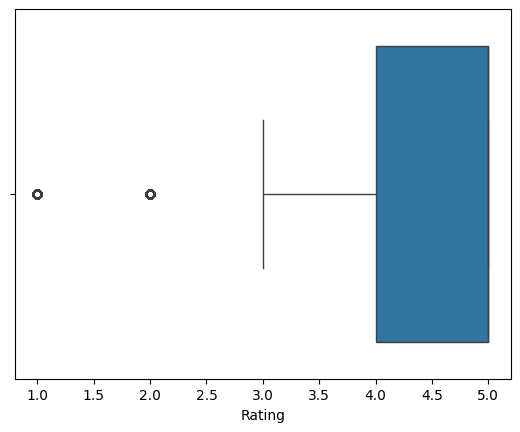

In [12]:
out_XTR = explore_outliers(amazon_ratings1, ['Rating'])

In [13]:
print('Percetage of outliers', len(out_XTR.get('Rating').get('indices'))/len(amazon_ratings1))

Percetage of outliers 0.1458


For this particular recommender system, we will not drop the outliers, since the rating histogram is too skewed and if we want to capture behaviours deviating from the trend, we need to keep those "outlier" ratings in the matrix. 

If we would have liked to remove the outliers we can do so with the following commented code for example: 

In [14]:
#Remove outliers
#amazon_ratings1.drop(out_XTR.get('Rating').get('indices'), inplace=True)

Build the ratings_matrix

In [15]:
ratings_matrix = amazon_ratings1.pivot_table(values='Rating', index='UserId', columns='ProductId')
ratings_matrix.head()

ProductId,1451646526,4057553908,753865058X,9788073409,9788080669,9790771584,9790778309,979079035X,9790790961,B00004TMFE,...,B00KAL5JAU,B00KD73PBQ,B00KECCJTY,B00KHH2VOY,B00KIWJ1W8,B00KNCUMDU,B00KQVTX06,B00KWE08Q0,B00L3KEIZO,B00LCLFMDG
UserId,,,,,,,,,,,,,,,,,,,,,
A00407141VL6SB77B1GGG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A00473363TJ8YSZ3YAGG9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0056746VLX0I5VJCFN6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A05198112VVJ1HUQ3SWU5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A05510841IANN1R9RQYTZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='Mean Rating', ylabel='Count'>

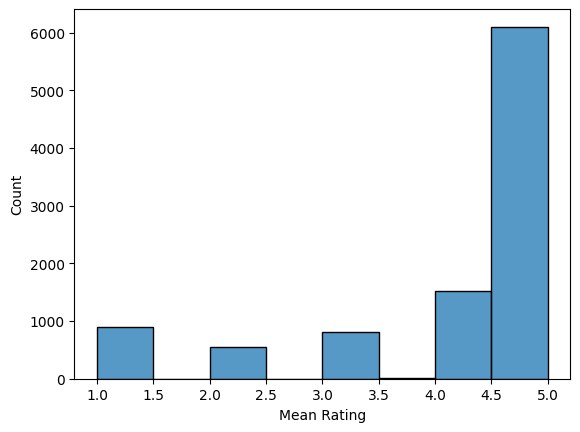

In [16]:
df = ratings_matrix
df['Mean Rating'] = df.mean(axis=1)
sns.histplot(x='Mean Rating', binwidth=0.5, data=df)

Sparsity in recommender systems measures the proportion of missing or unobserved interactions in the user-item matrix, indicating how many user-item pairs don't have recorded interactions. It is calculated as the number of missing values divided by the total number of possible values in the matrix. A high sparsity value indicates that most user-item pairs lack interactions, making it challenging to predict preferences. Conversely, a low sparsity value suggests more interactions are recorded, offering a richer dataset for making recommendations.

In [17]:
def print_sparsity(df):
  n_users = df.UserId.nunique()
  n_items = df.ProductId.nunique()
  n_ratings = len(df)
  rating_matrix_size = n_users * n_items
  sparsity = 1 - n_ratings / rating_matrix_size

  print(f"Number of users: {n_users}")
  print(f"Number of items: {n_items}")
  print(f"Number of available ratings: {n_ratings}")
  print(f"Number of all possible ratings: {rating_matrix_size}")
  print("-" * 40)
  print(f"SPARSITY: {sparsity * 100.0:.2f}%")

print_sparsity(amazon_ratings1)

Number of users: 9898
Number of items: 8132
Number of available ratings: 10000
Number of all possible ratings: 80490536
----------------------------------------
SPARSITY: 99.99%


In [18]:
item_rate_count = amazon_ratings1.groupby("ProductId")["UserId"].nunique().sort_values(ascending=False)

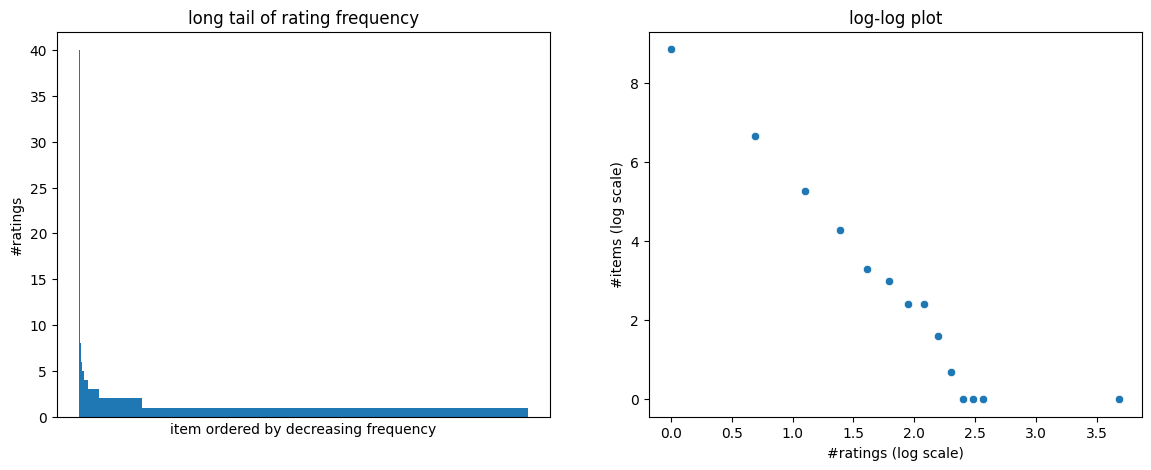

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
axes[0].bar(x=item_rate_count.index, height=item_rate_count.values, width=5.0, align="edge")
axes[0].set_xticks([])
axes[0].set(title="long tail of rating frequency", 
            xlabel="item ordered by decreasing frequency", 
            ylabel="#ratings")

count = item_rate_count.value_counts()
sns.scatterplot(x=np.log(count.index), y=np.log(count.values), ax=axes[1])
axes[1].set(title="log-log plot", xlabel="#ratings (log scale)", ylabel="#items (log scale)");

<Axes: xlabel='ProductId'>

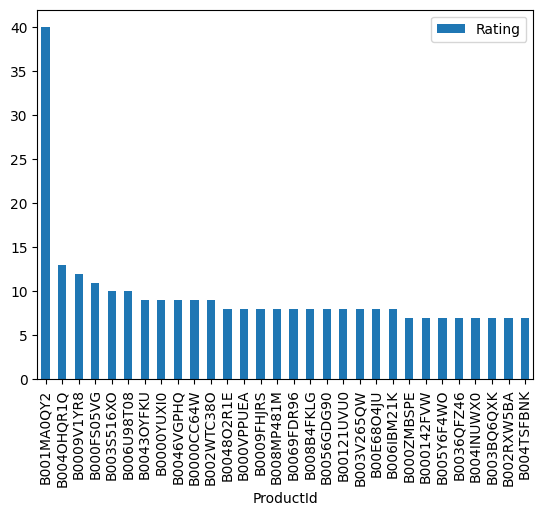

In [20]:
popular_products = pd.DataFrame(amazon_ratings1.groupby('ProductId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

#### **1. User-based recommendation**

In [21]:
amazon_ratings1.columns

Index(['UserId', 'ProductId', 'Rating'], dtype='object')

In [22]:
def userknn_cornac(df:pd.DataFrame):

  df = df.astype({'UserId':object, 'ProductId':object})
  records = df.to_records(index=False)
  result = list(records)

  K = 3  # number of nearest neighbors
  VERBOSE = False
  SEED = 42
  uknn_cosine = UserKNN(k=K, similarity="cosine", name="UserKNN-Cosine", verbose=VERBOSE)
  uknn_cosine_mc = UserKNN(k=K, similarity="cosine", mean_centered=True, name="UserKNN-Cosine-MC", verbose=VERBOSE)
  uknn_pearson = UserKNN(k=K, similarity="pearson", name="UserKNN-Pearson", verbose=VERBOSE)
  uknn_pearson_mc = UserKNN(k=K, similarity="pearson", mean_centered=True, name="UserKNN-Pearson-MC", verbose=VERBOSE)
  
  # Metrics
  rec_300 = cornac.metrics.Recall(k=300)
  rec_900 = cornac.metrics.Recall(k=900)
  prec_30 = cornac.metrics.Precision(k=30)
  rmse = cornac.metrics.RMSE()
  mae = cornac.metrics.MAE()
  
  ratio_split = RatioSplit(result, test_size=0.1, seed=SEED, verbose=VERBOSE)
  cornac.Experiment(eval_method=ratio_split,
                    models=[uknn_cosine, uknn_cosine_mc, uknn_pearson, uknn_pearson_mc],
                    metrics=[rec_300, rec_900, prec_30, rmse, mae],
                    ).run()
  
  userknn_models = {'uknn_cosine': uknn_cosine, 'uknn_cosine_mc': uknn_cosine_mc,
                'uknn_pearson': uknn_pearson, 'uknn_pearson_mc': uknn_pearson_mc}
  
  return userknn_models

userknn_models = userknn_cornac(amazon_ratings1)


TEST:
...
                   |    MAE |   RMSE | Precision@30 | Recall@300 | Recall@900 | Train (s) | Test (s)
------------------ + ------ + ------ + ------------ + ---------- + ---------- + --------- + --------
UserKNN-Cosine     | 1.0000 | 1.0000 |       0.0000 |     0.0000 |     0.0000 |    0.6138 |   0.1478
UserKNN-Cosine-MC  | 1.0000 | 1.0000 |       0.0000 |     0.0000 |     0.0000 |    0.5032 |   0.1237
UserKNN-Pearson    | 1.0000 | 1.0000 |       0.0000 |     0.0000 |     0.0000 |    0.4821 |   0.2163
UserKNN-Pearson-MC | 1.0000 | 1.0000 |       0.0000 |     0.0000 |     0.0000 |    0.5262 |   0.3650



**User profiling**

In [23]:
df_user_10k = pd.read_csv('ratings_Beauty.csv').set_index("UserId").drop('Timestamp', axis=1)
df_item_10k = pd.read_csv('ratings_Beauty.csv').set_index("ProductId").drop('Timestamp', axis=1)

In [24]:
df_user_10k.head()

,ProductId,Rating
UserId,,
A39HTATAQ9V7YF,0205616461,5.0
A3JM6GV9MNOF9X,0558925278,3.0
A1Z513UWSAAO0F,0558925278,5.0
A1WMRR494NWEWV,0733001998,4.0
A3IAAVS479H7M7,0737104473,1.0


array([[<Axes: title={'center': 'Rating'}>]], dtype=object)

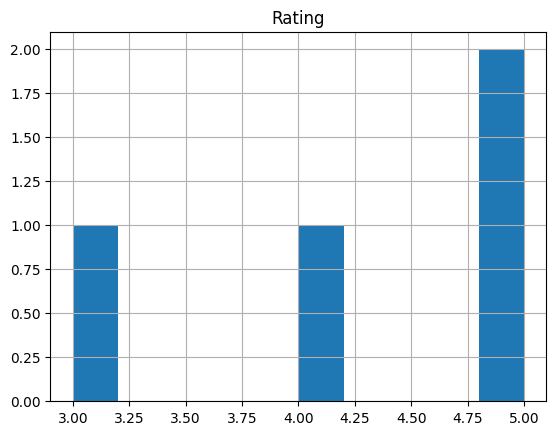

In [25]:
df_user_10k.loc['A39HTATAQ9V7YF'].hist()

In [26]:
df_item_10k.head()

,UserId,Rating
ProductId,,
0205616461,A39HTATAQ9V7YF,5.0
0558925278,A3JM6GV9MNOF9X,3.0
0558925278,A1Z513UWSAAO0F,5.0
0733001998,A1WMRR494NWEWV,4.0
0737104473,A3IAAVS479H7M7,1.0


In [27]:
users = df_item_10k.groupby('UserId')
users.get_group('A39HTATAQ9V7YF')

,UserId,Rating
ProductId,,
0205616461,A39HTATAQ9V7YF,5.0
B002OVV7F0,A39HTATAQ9V7YF,3.0
B0031IH5FQ,A39HTATAQ9V7YF,5.0
B006GQPZ8E,A39HTATAQ9V7YF,4.0


In [28]:
items = df_user_10k.groupby('ProductId')
items.get_group('130414643X')

,ProductId,Rating
UserId,,
A327B0I7CYTEJC,130414643X,4.0
A1BG8QW55XHN6U,130414643X,5.0
AIFAAVTUYHEHB,130414643X,4.0


Choose the model you like the most.

In [29]:
model = userknn_models.get('uknn_cosine')

In [30]:
def user_profiling(UID, model, user_df, TOPK=5):

  rating_mat = model.train_set.matrix

  UIDX = list(model.train_set.uid_map.items())[UID][0]

  print(f"UserID = {UIDX}")
  print("-" * 35)
  print(user_df.loc[UIDX])

  ratings = pd.DataFrame(rating_mat.toarray())
  user_ratings = ratings.loc[UID]
  top_rated_items = np.argsort(user_ratings)[-TOPK:]
  print(f"\nTOP {TOPK} RATED ITEMS BY USER {UID}:")
  print("-" * 35)
  print(user_df.iloc[top_rated_items.array])

model = userknn_models.get('uknn_cosine')

top_rated_items = user_profiling(8, model, df_user_10k)

UserID = A1MA7KAZCFKSZV
-----------------------------------
                 ProductId  Rating
UserId                            
A1MA7KAZCFKSZV  B000ALBLXE     5.0
A1MA7KAZCFKSZV  B000ALBLZ2     5.0
A1MA7KAZCFKSZV  B001G7PNDK     3.0
A1MA7KAZCFKSZV  B0041ZLOPU     5.0

TOP 5 RATED ITEMS BY USER 8:
-----------------------------------
                 ProductId  Rating
UserId                            
A16NAH39LN211W  B00004TMFE     5.0
A1ISPXMZL1IYSE  B00004TMFE     2.0
A149N75TZ34CE5  B00004TMFE     1.0
A1E5DVHYS3TQVG  B000052YM7     4.0
A3V3RE4132GKRO  130414089X     5.0


We can also predict the score that this users would have given to any item:

In [31]:
def uknn_get_scores(UID, model, user_df, TOPK=5):

    UIDX = list(model.train_set.uid_map.items())[UID][0]
    recommendations, scores = model.rank(UID)
    print(f"\nTOP {5} RECOMMENDATIONS FOR USER {UIDX}:")
    print("Scores:", scores[recommendations[:TOPK]])
    print(user_df.iloc[recommendations[:TOPK]])


In [32]:
uknn_get_scores(2, model, df_user_10k)


TOP 5 RECOMMENDATIONS FOR USER A9QUSEMHTXYTA:
Scores: [3.00000001 3.         3.         3.         3.        ]
                 ProductId  Rating
UserId                            
A1Z513UWSAAO0F  0558925278     5.0
A1E5DVHYS3TQVG  B000052YM7     4.0
A149N75TZ34CE5  B00004TMFE     1.0
A1ISPXMZL1IYSE  B00004TMFE     2.0
A16NAH39LN211W  B00004TMFE     5.0


### **2. Item-based**

In [33]:
def itemknn_cornac(df):
  df = df.astype({'UserId':object, 'ProductId':object})
  records = df.to_records(index=False)
  result = list(records)
  K = 50  # number of nearest neighbors
  VERBOSE = False
  SEED = 42
  iknn_cosine = ItemKNN(k=K, similarity="cosine", name="ItemKNN-Cosine", verbose=VERBOSE)
  iknn_pearson = ItemKNN(k=K, similarity="pearson", name="ItemKNN-Pearson", verbose=VERBOSE)
  iknn_pearson_mc = ItemKNN(k=K, similarity="pearson", mean_centered=True, name="ItemKNN-Pearson-MC", verbose=VERBOSE)
  iknn_adjusted = ItemKNN(k=K, similarity="cosine", mean_centered=True, name="ItemKNN-AdjustedCosine", verbose=VERBOSE)

  # Metrics
  rmse = cornac.metrics.RMSE()
  mae = cornac.metrics.MAE()

  ratio_split = RatioSplit(result, test_size=0.1, seed=SEED, verbose=VERBOSE)
  cornac.Experiment(eval_method=ratio_split,
                    models=[iknn_cosine, iknn_pearson, iknn_pearson_mc, iknn_adjusted],
                    metrics=[rmse, mae],
                    ).run()
  itemknn_models = {'iknn_cosine': iknn_cosine, 'iknn_pearson': iknn_pearson,
                'iknn_pearson_mc': iknn_pearson_mc, 'iknn_adjusted': iknn_adjusted}
  return itemknn_models

itemknn_models = itemknn_cornac(amazon_ratings1)


TEST:
...
                       |    MAE |   RMSE | Train (s) | Test (s)
---------------------- + ------ + ------ + --------- + --------
ItemKNN-Cosine         | 1.0000 | 1.0000 |    0.4198 |   0.0010
ItemKNN-Pearson        | 1.0000 | 1.0000 |    0.4119 |   0.0008
ItemKNN-Pearson-MC     | 1.0000 | 1.0000 |    0.3846 |   0.0014
ItemKNN-AdjustedCosine | 1.0000 | 1.0000 |    0.3730 |   0.0012



In [34]:
def item_profiling(UID, model, item_df, TOPK=5):

  rating_mat = model.train_set.matrix

  UIDX = list(model.train_set.iid_map.items())[UID][0]

  print(f"ProductID = {UIDX}")
  print("-" * 35)
  print(item_df.loc[UIDX])

  ratings = pd.DataFrame(rating_mat.toarray())
  item_ratings = ratings.iloc[UID]
  top_rated_items = np.argsort(item_ratings)[-TOPK:]
  print(f"\nTOP {TOPK} RECOMMENDED USERS FOR ITEM {UID}:")
  print("-" * 35)
  print(df_item_10k.iloc[top_rated_items.array])

In [35]:
model = itemknn_models.get('iknn_adjusted')

In [36]:
top_rated_items = item_profiling(2, model, df_item_10k)

ProductID = B0011GD5CM
-----------------------------------
                    UserId  Rating
ProductId                         
B0011GD5CM  A11RU2YNML78P1     5.0
B0011GD5CM  A1POFYCQ9096DU     5.0
B0011GD5CM  A2UO3JTBIQV1UM     5.0
B0011GD5CM  A2WBFDC7SDHPT6     5.0
B0011GD5CM   AFEU4FI71UYNJ     5.0
B0011GD5CM  A3QV0ZJJ7R8R91     5.0
B0011GD5CM     AZP9Z4R8JKE     5.0
B0011GD5CM   A9QUSEMHTXYTA     3.0
B0011GD5CM  A1NX16398HCGX1     5.0
B0011GD5CM   A8RIPCG68GRZN     5.0
B0011GD5CM   A1PO9TVZO5BOV     1.0

TOP 5 RECOMMENDED USERS FOR ITEM 2:
-----------------------------------
                    UserId  Rating
ProductId                         
B00004TMFE  A16NAH39LN211W     5.0
B00004TMFE  A1ISPXMZL1IYSE     2.0
B00004TMFE  A149N75TZ34CE5     1.0
B000052YM7  A1E5DVHYS3TQVG     4.0
0558925278  A1Z513UWSAAO0F     5.0


array([[<Axes: title={'center': 'Rating'}>]], dtype=object)

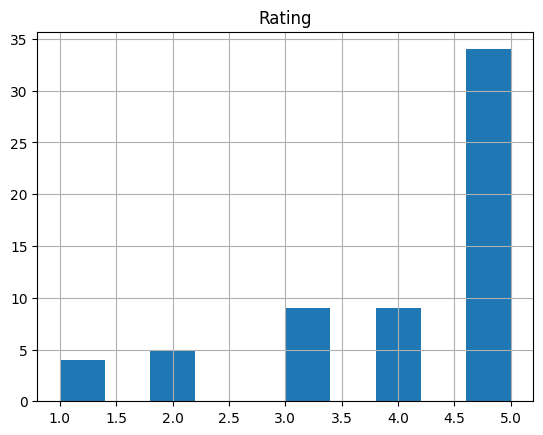

In [37]:
df_item_10k.loc['B0050QLE4U'].hist()

In [38]:
def itemknn_get_scores(UID, model, item_df, TOPK=5):

    UIDX = list(model.train_set.iid_map.items())[UID][0]
    recommendations, scores = model.rank(UID)
    print(f"\nTOP {5} USERS FOR ITEM {UIDX}:")
    print("Scores:", scores[recommendations[:TOPK]])
    print(item_df.iloc[recommendations[:TOPK]])

itemknn_get_scores(3, model, df_item_10k)


TOP 5 USERS FOR ITEM B008YKNHN0:
Scores: [5.00000001 5.         5.         5.         5.        ]
                    UserId  Rating
ProductId                         
0733001998  A1WMRR494NWEWV     4.0
B000052YM7  A1E5DVHYS3TQVG     4.0
B00004TMFE  A149N75TZ34CE5     1.0
B00004TMFE  A1ISPXMZL1IYSE     2.0
B00004TMFE  A16NAH39LN211W     5.0


### **3. Model-Based**

**3.1 SVD**

In [39]:
from numpy.linalg import matrix_rank

mu = 0
R_df = amazon_ratings1[:1000].pivot(index="UserId", columns="ProductId", values="Rating").fillna(mu)
R = R_df.to_numpy()
#center the ratings
user_ratings_mean = np.mean(R, axis=1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

print('Shape of rating matrix:', R.shape)
print('-'*35)

rank_rating_matrix = matrix_rank(R_demeaned)
print('Rank of rating matrix:', rank_rating_matrix)

Shape of rating matrix: (1000, 964)
-----------------------------------


Rank of rating matrix: 963


It usually takes a very long time to train these SVD decomposition, but we can use either sklearn or cornac for optimised methods if the dataset is too large.

`With Cornac`

In [40]:
def svd_cornac(df, k_min=10, k_max=2000, step=100):
  df = df.astype({'UserId':object, 'ProductId':object})
  records = df.to_records(index=False)
  result = list(records)
  
  VERBOSE = False
  SEED = 42

  svd_models = []
  k_values = np.arange(k_min, k_max, step)
  for k in k_values:
    svd_models.append(SVD(name='SVD'+str(k), k=k))

  # Metrics
  rmse = cornac.metrics.RMSE()
  
  ratio_split = RatioSplit(result, test_size=0.1, seed=SEED, verbose=VERBOSE)
  svd_experiment = cornac.Experiment(eval_method=ratio_split,
                    models=svd_models,
                    show_validation=True,
                    metrics=[rmse],
                    )
  svd_experiment.run()

  return svd_models, svd_experiment

svd_models, svd_experiment = svd_cornac(amazon_ratings1, 100, 500, 50)


TEST:
...
       |   RMSE | Train (s) | Test (s)
------ + ------ + --------- + --------
SVD100 | 0.8788 |    0.0753 |   0.0006
SVD150 | 0.8794 |    0.0505 |   0.0006
SVD200 | 0.8786 |    0.0656 |   0.0006
SVD250 | 0.8796 |    0.0824 |   0.0005
SVD300 | 0.8778 |    0.1004 |   0.0005
SVD350 | 0.8779 |    0.1149 |   0.0005
SVD400 | 0.8791 |    0.1293 |   0.0005
SVD450 | 0.8788 |    0.1490 |   0.0005



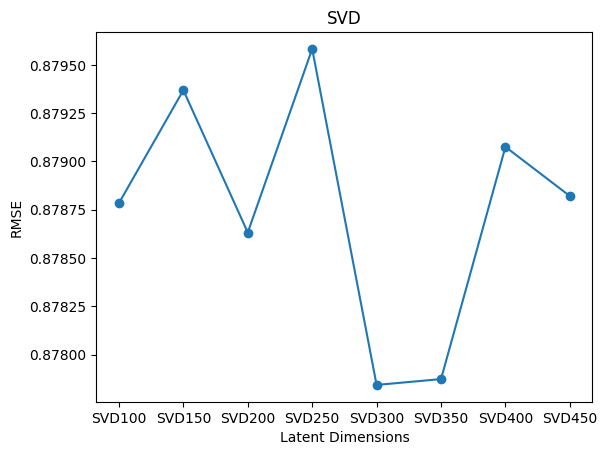

In [41]:
def plot_rmse_cornac(experiment, metric_name='RMSE'):
    metric_values = []
    names_models = []
    for i in range(len(experiment.result)):
        metric_values.append(svd_experiment.result[i].metric_avg_results.get(metric_name))
        names_models.append(svd_experiment.result[i].model_name)

    plt.xlabel('Latent Dimensions')
    plt.ylabel('RMSE')
    plt.title('SVD')
    plt.plot(names_models, metric_values, 'o-')
    plt.show()
plot_rmse_cornac(svd_experiment)

We could have also done any of the other plots from PCA to check which dimension to choose as latent dimension.

In [42]:
df = amazon_ratings1.astype({'UserId':object, 'ProductId':object})
records = df.to_records(index=False)
result = list(records)

# Instantiate an evaluation method to split data into train and test sets.
ratio_split = cornac.eval_methods.RatioSplit(
    data=amazon_ratings1.values, test_size=0.1, verbose=True
)

# Instantiate the models of interest
bo = cornac.models.BaselineOnly(
    max_iter=30, learning_rate=0.01, lambda_reg=0.02, verbose=True
)
svd = cornac.models.SVD(
    k=400, max_iter=30, learning_rate=0.01, lambda_reg=0.02, verbose=True
)

# Instantiate evaluation measures
mae = cornac.metrics.MAE()
rmse = cornac.metrics.RMSE()

# Instantiate and run an experiment.
cornac.Experiment(eval_method=ratio_split, models=[bo, svd], metrics=[mae, rmse]).run()

rating_threshold = 1.0
exclude_unknowns = True
---
Training data:
Number of users = 8918
Number of items = 7435
Number of ratings = 9000
Max rating = 5.0
Min rating = 1.0
Global mean = 4.1
---
Test data:
Number of users = 8918
Number of items = 7435
Number of ratings = 5
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 8918
Total items = 7435

[BaselineOnly] Training started!


  0%|          | 0/30 [00:00<?, ?it/s]

Optimization finished!

[BaselineOnly] Evaluation started!


Rating:   0%|          | 0/5 [00:00<?, ?it/s]


[SVD] Training started!


  0%|          | 0/30 [00:00<?, ?it/s]

Optimization finished!

[SVD] Evaluation started!


Rating:   0%|          | 0/5 [00:00<?, ?it/s]


TEST:
...
             |    MAE |   RMSE | Train (s) | Test (s)
------------ + ------ + ------ + --------- + --------
BaselineOnly | 1.9002 | 1.9002 |    0.0228 |   0.0056
SVD          | 1.9011 | 1.9011 |    0.1801 |   0.0045



Any cornac model includes several useful functions for rating and ranking once the model ahs been trained: 

In [55]:
def recommend_products(index, model, data, num_products=5):

    print('Name of Model:', svd.name)
    
    # Rank all test items for a given user.
    df_rank = pd.DataFrame({'ranked_items': model.rank(index)[0], 'item_scores': model.rank(index)[1]}, 
                           columns=['ranked_items', 'item_scores'])
    print('Target UserId', amazon_ratings1.iloc[index].UserId)

    df_rank.sort_values('item_scores', ascending=False, inplace=True)

    print('Recommended products:', data.iloc[df_rank.head(num_products).ranked_items.values]['ProductId'].values)
    print('Predicted scoreds: ', df_rank.head(num_products).item_scores.values)
    r_pred = df_rank.head(num_products).item_scores.values

recommend_products(1, svd, amazon_ratings1)




Name of Model: SVD
Target UserId A3V2Z5651OC7R8
Recommended products: ['B007FJ5NOC' 'B0028ZO2Q8' 'B000FQ8BW8' 'B007HOCQVS' 'B001BDRBHK']
Predicted scoreds:  [4.9700503 4.9231067 4.92162   4.921423  4.9071784]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

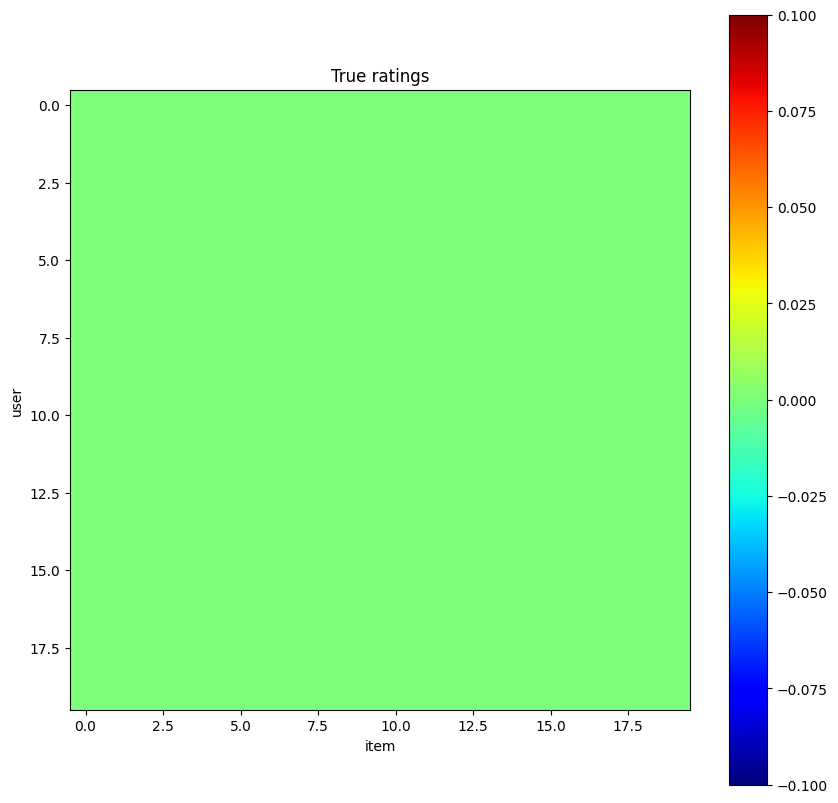

<Figure size 1000x1000 with 0 Axes>

In [56]:
nusers = 20
nitems = 20


plt.figure(figsize=(10, 10))
plt.imshow(R[:nusers, :nitems], cmap="jet")
plt.xlabel("item")
plt.ylabel("user")
plt.title("True ratings")
plt.colorbar()


plt.figure(figsize=(10, 10))
plt.imshow(R_pred[:nusers, :nitems], cmap="jet")
plt.xlabel("item")
plt.ylabel("user")
plt.title("Predicted ratings")
plt.colorbar()

MSE = np.square(np.subtract(R[:nusers, :nitems], R_pred[:nusers, :nitems]))

plt.figure(figsize=(10, 10))
plt.imshow(MSE, cmap="jet")
plt.xlabel("item")
plt.ylabel("user")
plt.title("Error in prediction")
plt.colorbar()

**Matrix Factorisation**

In [ ]:
from cornac.models import MF, NMF, BaselineOnly

In [ ]:
def mf_cornac(df):
  df = df.astype({'UserId':object, 'ProductId':object})
  records = df.to_records(index=False)
  result = list(records)
  K = 10
  VERBOSE = False
  SEED = 42
  lbd = 0.01
  baseline = BaselineOnly(max_iter=20, learning_rate=0.01, lambda_reg=lbd, verbose=VERBOSE)
  mf1 = MF(k=K, max_iter=20, learning_rate=0.01, lambda_reg=0.0, use_bias=False, verbose=VERBOSE, seed=SEED, name=f"MF(K={K})")
  mf2 = MF(k=K, max_iter=20, learning_rate=0.01, lambda_reg=lbd, use_bias=False, verbose=VERBOSE, seed=SEED, name=f"MF(K={K},lambda={lbd:.4f})")
  mf3 = MF(k=K, max_iter=20, learning_rate=0.01, lambda_reg=lbd, use_bias=True, verbose=VERBOSE, seed=SEED, name=f"MF(K={K},bias)")
  nmf = NMF(k=K, max_iter=200, learning_rate=0.01, use_bias=False, verbose=VERBOSE, seed=SEED, name=f"NMF(K={K})")
  ratio_split = RatioSplit(result, test_size=0.1, seed=SEED, verbose=VERBOSE)
  cornac.Experiment(eval_method=ratio_split,
                    models=[baseline, mf1, mf2, mf3, nmf],
                    metrics=[cornac.metrics.RMSE()],
                    ).run()
  
  mf_models ={'baseline':baseline, 'mf1':mf1, 'mf2':mf2, 'mf3':mf3, 'nmf':nmf}
  return mf_models

mf_models = mf_cornac(amazon_ratings1)


TEST:
...
                       |   RMSE | Train (s) | Test (s)
---------------------- + ------ + --------- + --------
BaselineOnly           | 0.8795 |    0.0009 |   0.0005
MF(K=10)               | 3.5000 |    0.0047 |   0.0004
MF(K=10,lambda=0.0100) | 3.5000 |    0.0045 |   0.0004
MF(K=10,bias)          | 0.8795 |    0.0046 |   0.0004
NMF(K=10)              | 1.6067 |    0.1088 |   0.0005



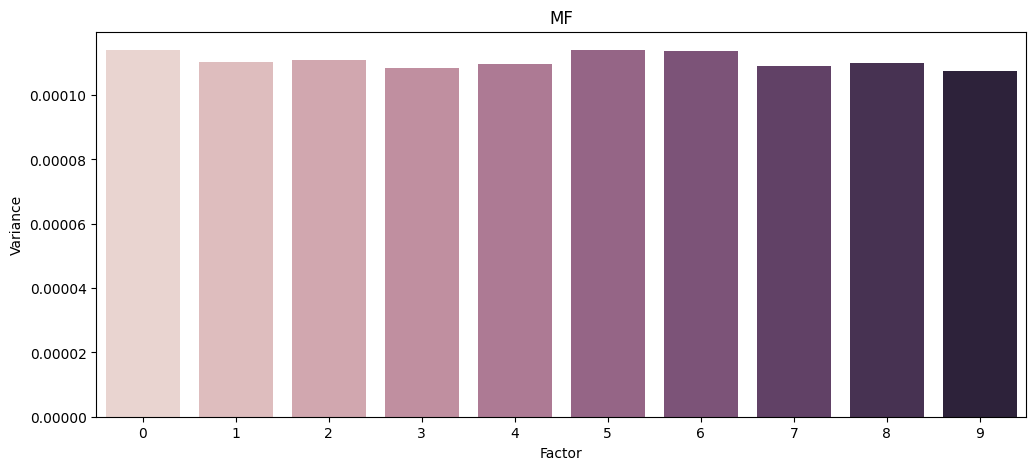

In [ ]:
K=10
model = mf_models.get('mf3')
var_df = pd.DataFrame({"Factor": np.arange(K), "Variance": np.var(model.i_factors, axis=0)})
fig, ax = plt.subplots(figsize=(12, 5))
plt.title('MF')
sns.barplot(x="Factor", y="Variance", data=var_df, hue='Factor', legend=False, ax=ax);

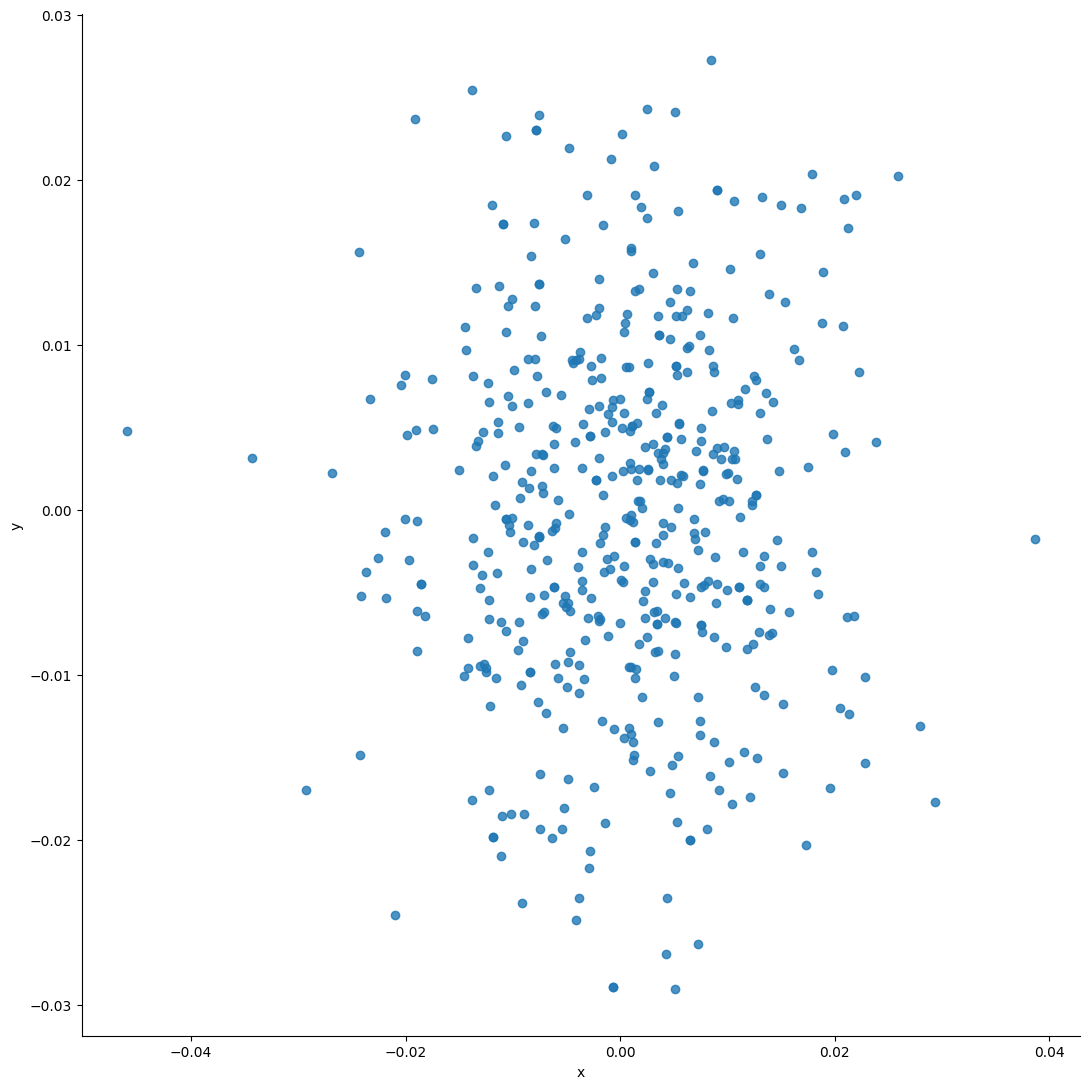

In [ ]:
TOP2F = (0, 2)
SAMPLE_SIZE = 500

mf = model
rng = np.random.RandomState(42)
sample_inds = rng.choice(np.arange(mf.i_factors.shape[0]), size=SAMPLE_SIZE)
sample_df = pd.DataFrame(data=mf.i_factors[sample_inds][:, TOP2F], columns=["x", "y"])
sns.lmplot(x="x", y="y", data=sample_df, height=11.0, fit_reg=False)

In [ ]:
def pick_centroids(data, k):
    indexes = np.random.choice(len(data), size=k, replace=False)
    centroids = data[indexes]
    return centroids

def assign_cluster(data, centroids):
    # Pairwise squared L2 distances. Shape [n, k]
    distances = ((data[:, np.newaxis] - centroids)**2).sum(axis=2)
    # find closest centroid index. Shape [n]
    clusters = np.argmin(distances, axis=1)
    return clusters

def update_centroids(data, clusters, k):
    # Mean positions of data within clusters
    centroids = [np.mean(data[clusters == i], axis=0) for i in range(k)]
    return np.array(centroids)

In [ ]:
class KMEANS:
    def __init__(self, k):
        self.k = k
        
    def fit(self, data, steps=20):
        self.centroids = pick_centroids(data, self.k)
        for step in range(steps):
            clusters = assign_cluster(data, self.centroids)
            self.centroids = update_centroids(data, clusters, self.k)
            
    def predict(self, data):
        return assign_cluster(data, self.centroids)

In [ ]:
kmeans = KMEANS(k=3)
data = sample_df.to_numpy()
kmeans.fit(data)
clusters = kmeans.predict(data)

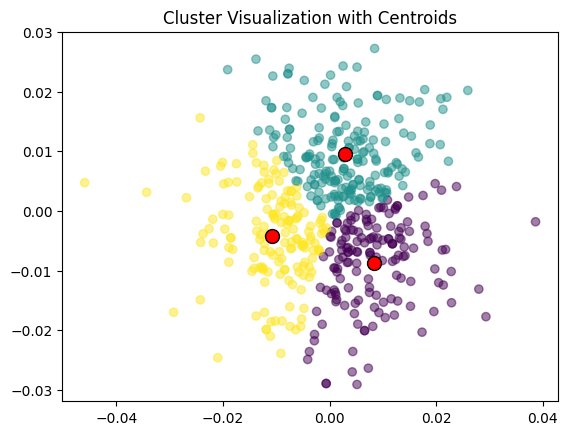

In [ ]:
plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis', alpha=0.5) 
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c="red", s=100, edgecolor='black', label='Centroids')
plt.title('Cluster Visualization with Centroids')  
plt.grid(False)
plt.show()

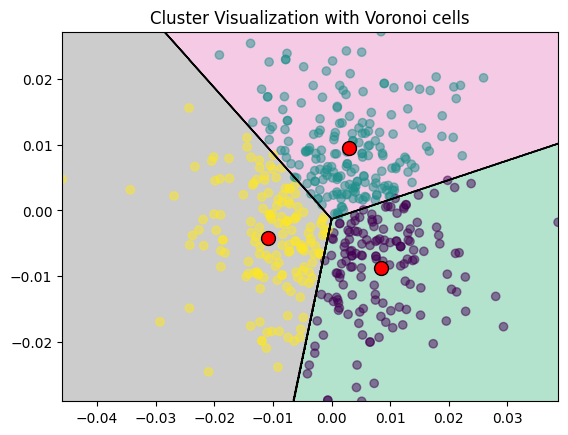

In [ ]:
def plot_decision_boundaries(clusterer, X, resolution=1000):
    plt.figure()
    mins = X.min(axis=0) 
    maxs = X.max(axis=0) 
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution), np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.title('Cluster Visualization with Voronoi cells') 
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1, colors="k")
    plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis', alpha=0.5) 
    plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c="red", s=100, edgecolor='black', label='Centroids')
    plt.show()
plot_decision_boundaries(kmeans, data)